In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import featuretools as ft
from featuretools import selection
from sklearn.preprocessing import LabelEncoder


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import seaborn as sns



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve




In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
TRAIN_DATASET_PATH = 'course_project/course_project_train.csv'
TEST_DATASET_PATH = 'course_project/course_project_test.csv'
TARGET_NAME = 'Credit Default'
df_train  = pd.read_csv(TRAIN_DATASET_PATH)

df_test = pd.read_csv(TEST_DATASET_PATH)
target = df_train['Credit Default']
#df_train = df_train.drop(['Credit Default'],axis = 1)




In [4]:
df_train['Test'] = False
df_test['Test'] = True
df_test['Credit Default'] = np.nan
app = df_train.append(df_test, ignore_index=True, sort=False)

In [5]:
def fill(df):
    df['Months since last delinquent'].fillna(0,inplace=True )
    df['Credit Score'].fillna(0,inplace=True )
    df['Bankruptcies'].fillna(0,inplace= True)
    df['Annual Income'].fillna(df['Annual Income'].median(),inplace=True )
    
    return df

In [6]:
app = fill(app)
app['Index'] = app.index

In [7]:
for cat_colname in app.select_dtypes(include='object').columns:
    app = pd.concat([app, pd.get_dummies(app[cat_colname], prefix=cat_colname)], axis=1)

In [8]:
es = ft.EntitySet(id='id')




In [9]:
es = es.entity_from_dataframe(entity_id='Credit Default',
                              dataframe=app,index = 'Index')

In [10]:
BOOL = ft.variable_types.Boolean
variable_types = {'Years in current job_1 year': BOOL, 'Years in current job_10+ years': BOOL,
       'Years in current job_2 years': BOOL, 'Years in current job_3 years': BOOL,
       'Years in current job_4 years': BOOL, 'Years in current job_5 years': BOOL,
       'Years in current job_6 years': BOOL, 'Years in current job_7 years': BOOL,
       'Years in current job_8 years': BOOL, 'Years in current job_9 years': BOOL,
       'Years in current job_< 1 year': BOOL, 'Purpose_business loan': BOOL,
       'Purpose_buy a car': BOOL, 'Purpose_buy house': BOOL, 'Purpose_debt consolidation': BOOL,
       'Purpose_educational expenses': BOOL, 'Purpose_home improvements': BOOL,
       'Purpose_major purchase': BOOL, 'Purpose_medical bills': BOOL, 'Purpose_moving': BOOL,
       'Purpose_other': BOOL, 'Purpose_renewable energy': BOOL, 'Purpose_small business': BOOL,
       'Purpose_take a trip': BOOL, 'Purpose_vacation': BOOL, 'Purpose_wedding': BOOL,
       'Term_Long Term': BOOL, 'Term_Short Term': BOOL,'Home Ownership_Have Mortgage': BOOL, 'Home Ownership_Home Mortgage': BOOL,
       'Home Ownership_Own Home': BOOL, 'Home Ownership_Rent': BOOL}

In [11]:
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe=app,
                              index='Index',
                              variable_types=variable_types)

In [12]:
agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['cum_sum']

In [13]:
dfs_feat, dfs_defs = ft.dfs(entityset=es,
                            target_entity='Credit Default',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives, 
                            verbose = True,
                            max_depth=2, n_jobs=2)

Built 95 features
EntitySet scattered to 2 workers in 6 seconds
Elapsed: 00:01 | Progress: 100%|██████████


In [14]:
dfs_feat = selection.remove_low_information_features(dfs_feat)

In [15]:
dfs_feat= dfs_feat.drop(['Home Ownership','Years in current job','Bankruptcies','Purpose','Test','CUM_SUM(Credit Default)','Term'],1)


In [16]:
dfs_feat.drop('Credit Default',1,inplace = True)
dfs_feat = dfs_feat.rename({'Years in current job_< 1 year': 'Years in current job_ b1 year'}, axis=1) 
dfs_feat = dfs_feat.rename({'CUM_SUM(Years in current job_< 1 year)':'CUM_SUM(Years in current job_b 1 year)'},axis =1)

In [17]:
dfs_feat.shape 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_feat = scaler.fit_transform(dfs_feat)

In [18]:
df_train = dfs_feat[:len(target)]
df_test = dfs_feat[len(target):]

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_train = dfs_feat[:len(target)]
df_test = dfs_feat[len(target):]
chi_selector = SelectKBest(chi2, k=50)
chi_selector.fit(df_train, target)
chi_support = chi_selector.get_support()
chi_feature = df_train.loc[:,chi_support].columns.tolist()
df_train = df_train[chi_feature]
df_test = df_test[chi_feature]
print(str(len(chi_feature)), 'selected features')

50 selected features


In [20]:
import xgboost as xgb, catboost as catb

In [21]:
def balance_df_by_target(df):

    target_counts = df['Credit Default'].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df["Credit Default"] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [22]:

X_train, X_test, y_train, y_test = train_test_split(df_train, target, shuffle=True, test_size=0.25, random_state=211)

In [23]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing)
    
df_balanced['Credit Default'].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [24]:
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [27]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [28]:
from sklearn.metrics import f1_score
from mlens.ensemble import SuperLearner
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



ensemble = SuperLearner(scorer=f1_score, random_state=42)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=42), LogisticRegression(),KNeighborsClassifier(),])

# Build the second layer
ensemble.add([LogisticRegression(),SVC()])

# Attach the final meta estimator
ensemble.add_meta(xgb.XGBClassifier())

[MLENS] backend: threading


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...0111dd0>)],
   n_jobs=-1, name='group-2', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function f1_score at 0x1a20111dd0>, shuffle=False,
       verbose=False)

In [29]:
ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  kneighborsclassifier         0.51     0.00  0.03  0.01  0.57  0.00
layer-1  logisticregression           0.25     0.10  0.08  0.00  0.01  0.01
layer-1  randomforestclassifier       0.73     0.00  0.34  0.11  0.01  0.00
layer-2  logisticregression           0.73     0.00  0.01  0.00  0.00  0.00
layer-2  svc                          0.73     0.00  0.24  0.04  0.19  0.05



In [30]:
f1_score(preds,y_test)

0.4620535714285714

In [31]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.59      0.81      0.68      4047
           1       0.53      0.28      0.37      3156

    accuracy                           0.58      7203
   macro avg       0.56      0.55      0.53      7203
weighted avg       0.57      0.58      0.55      7203

TEST

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      1340
           1       0.35      0.28      0.31       535

    accuracy                           0.65      1875
   macro avg       0.54      0.53      0.54      1875
weighted avg       0.62      0.65      0.63      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1063  277
1                387  148


In [32]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4047
           1       0.95      0.89      0.92      3156

    accuracy                           0.93      7203
   macro avg       0.94      0.93      0.93      7203
weighted avg       0.93      0.93      0.93      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1340
           1       0.58      0.51      0.54       535

    accuracy                           0.76      1875
   macro avg       0.70      0.68      0.69      1875
weighted avg       0.75      0.76      0.75      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1147  193
1                264  271


In [35]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
 
def hyperopt_xgb_score(params):
    clf = xgb.XGBClassifier(**params)
    current_score = cross_val_score(clf, df_train, target, cv=3).mean()
    print(current_score, params)
    return -current_score
space_xgb2 = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            'nthread': 4,
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'reg_alpha':hp.choice('reg_alpha',[1e-5, 1e-2, 0.1, 1, 100])
    
        }
best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.6779699353338563                                  
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 838, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 1, 'silent': 1, 'subsample': 0.65, 'tree_method': 'exact'}
0.6890374028326511                                                            
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 0.75, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 369, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 1e-05, 'silent': 1, 'subsample': 0.75, 'tree_method': 'exact'}
0.6471546770914149                                                            
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 153, 'nthread': 4,

In [40]:
model_xgb = xgb.XGBClassifier(colsample_bytree =0.95, eta= 0.25,gamma = 0.75, max_depth= 8, 
                              n_estimators= 269,min_child_weight=6.0,subsample=0.75,reg_alpha =30,
                              reg_lambda =30,random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      4047
           1       0.78      0.64      0.70      3156

    accuracy                           0.76      7203
   macro avg       0.77      0.75      0.75      7203
weighted avg       0.76      0.76      0.76      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1340
           1       0.54      0.54      0.54       535

    accuracy                           0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.74      0.74      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1099  241
1                248  287


In [41]:
b = model_xgb.predict(df_test)
a = pd.read_csv('sampleSubmission.csv')
a['Credit Default'] = b.astype(int)
a.to_csv('xgb4.csv',index = False) #score 0.55156

In [61]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
cv=KFold(n_splits=3, random_state=21, shuffle=True)
params = {'n_estimators':[50, 100, 200,500,1000], 
          'max_depth':[1,2,3, 5, 7],
          'learning_rate':[ 0.001,0.005,0.01, 0.05, 0.1],
          'l2_leaf_reg':range(2, 50),
          'rsm':[0.75, 1.0],
          'subsample': [0.5, 1, 0.05],
          'l2_leaf_reg':range(1, 50)}
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

{'subsample': 1,
 'rsm': 0.75,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1,
 'l2_leaf_reg': 20}

In [64]:

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,l2_leaf_reg= 27,
                                      silent=True,subsample = 1,rsm=0.75, random_state=17)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      4047
           1       0.76      0.54      0.63      3156

    accuracy                           0.72      7203
   macro avg       0.73      0.70      0.70      7203
weighted avg       0.73      0.72      0.71      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1340
           1       0.56      0.52      0.54       535

    accuracy                           0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1124  216
1                258  277


In [65]:
b = final_model.predict(df_test)
a = pd.read_csv('sampleSubmission.csv')
a['Credit Default'] = b.astype(int)
a.to_csv('ctb5.csv',index = False) #score 0.50839

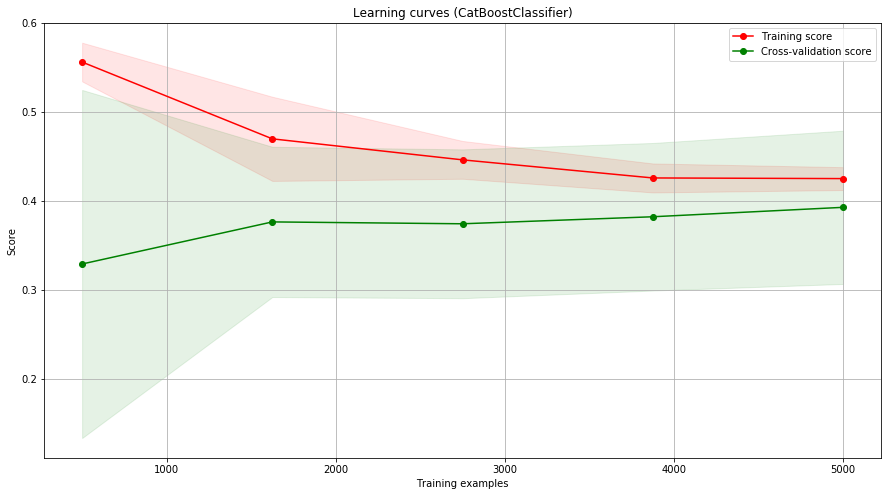

In [66]:
show_learning_curve_plot(final_model, df_train, target)

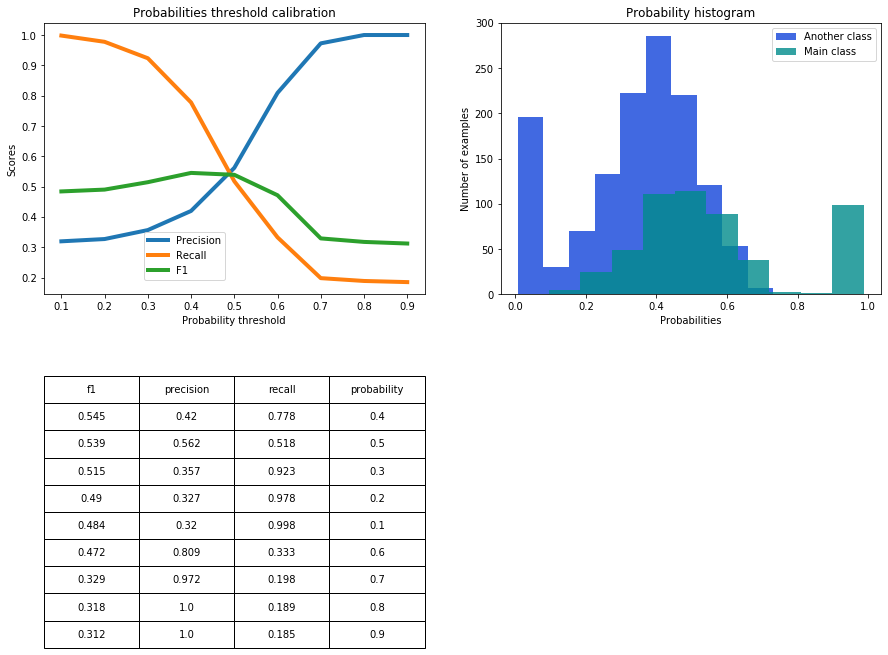

In [68]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
y_test_pred_probs = final_model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

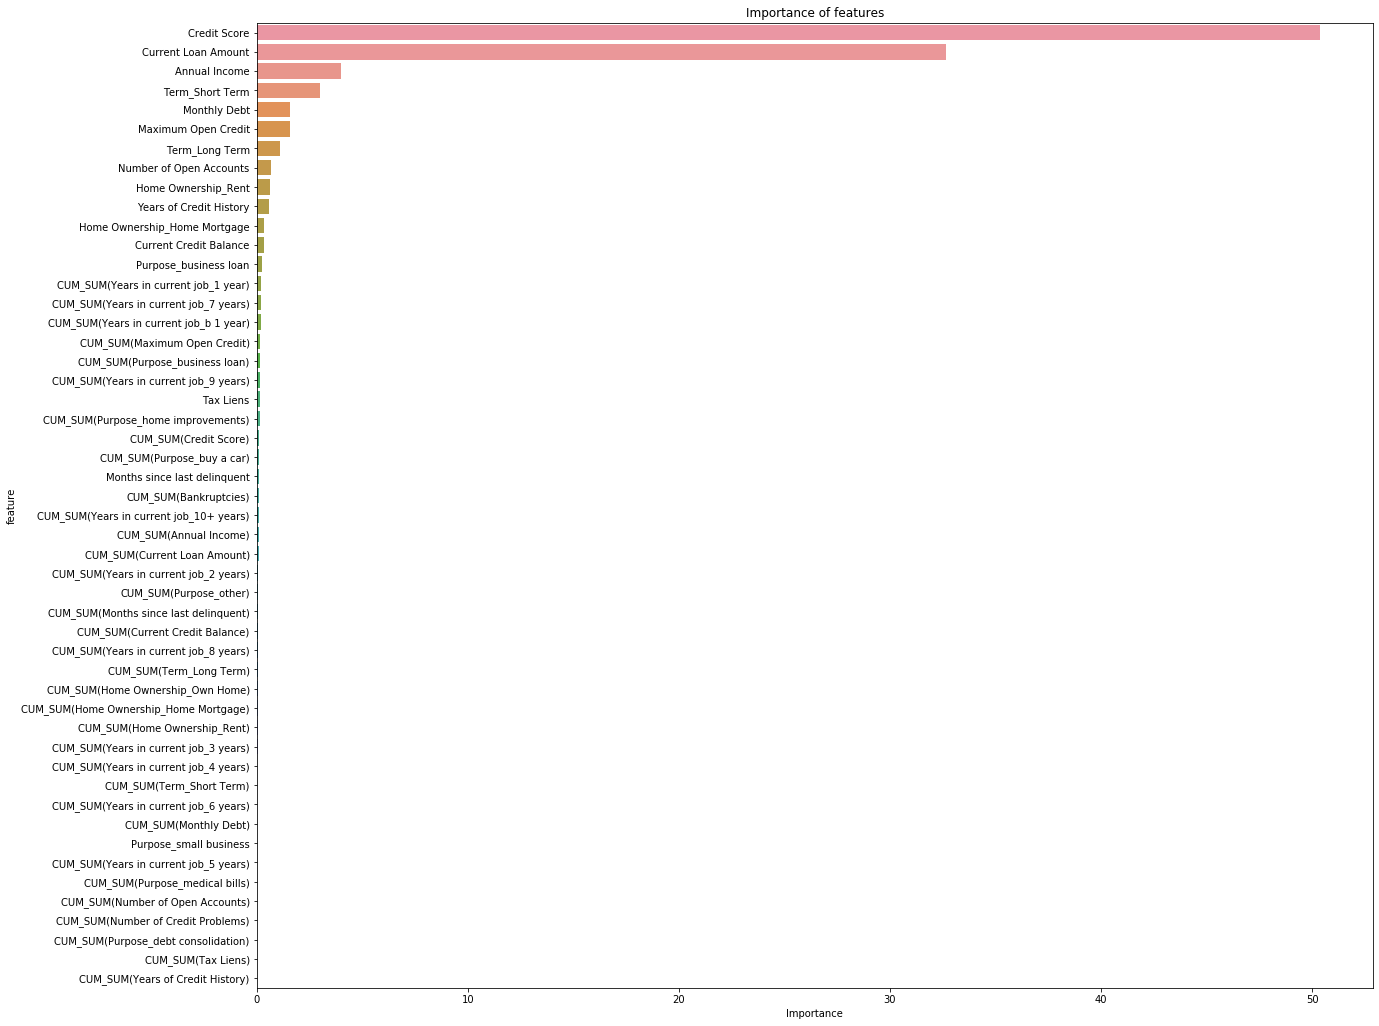

In [70]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

In [72]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=1, learning_rate=0.1,l2_leaf_reg= 17,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      4047
           1       0.72      0.56      0.63      3156

    accuracy                           0.71      7203
   macro avg       0.71      0.70      0.70      7203
weighted avg       0.71      0.71      0.71      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1340
           1       0.54      0.53      0.54       535

    accuracy                           0.74      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.74      0.74      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1100  240
1                249  286


Точнее всего оказался XGboost